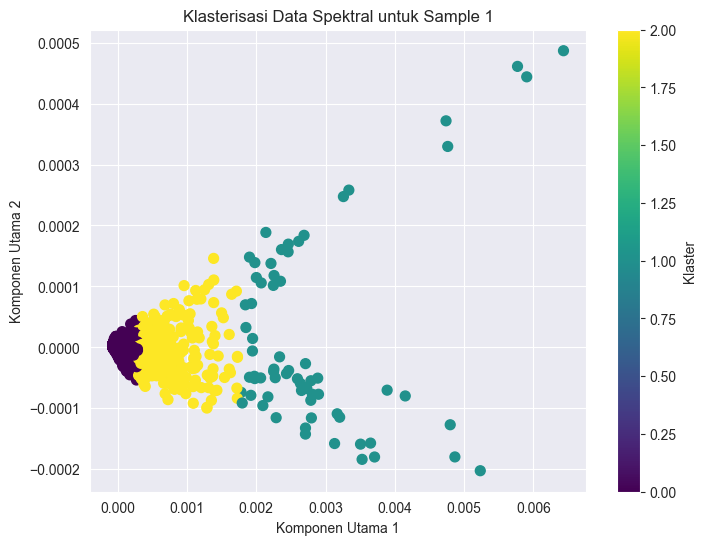

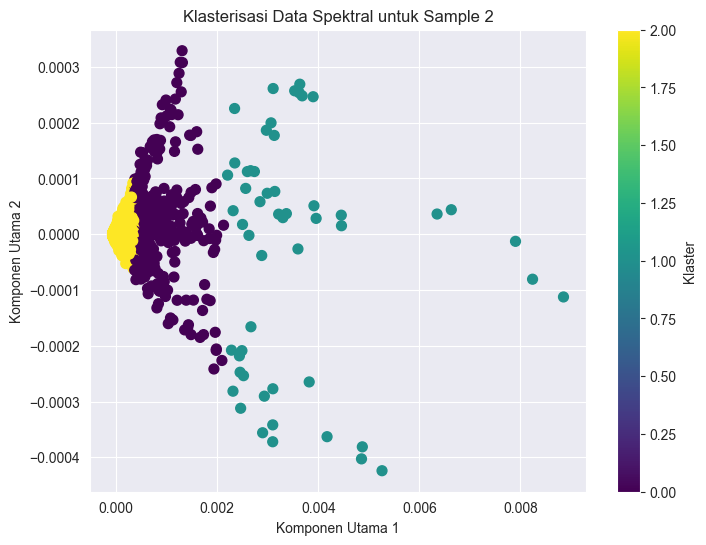

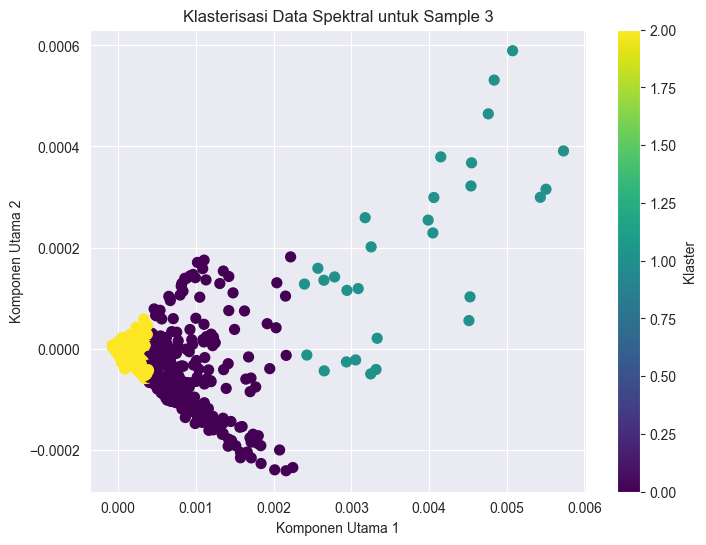

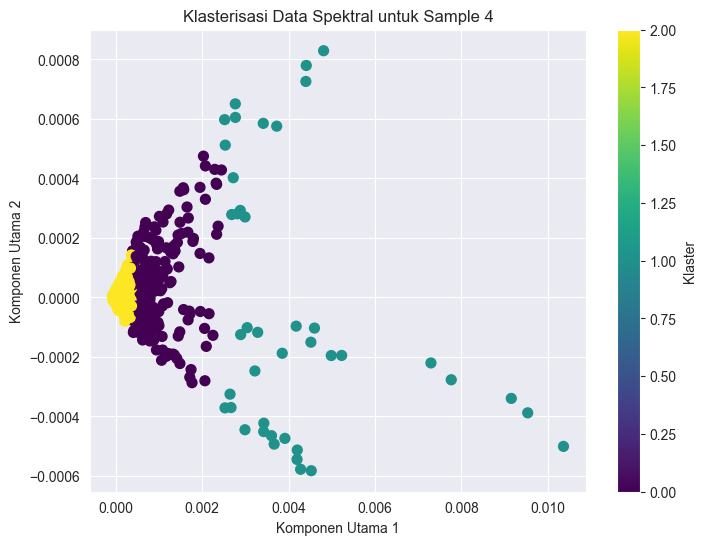

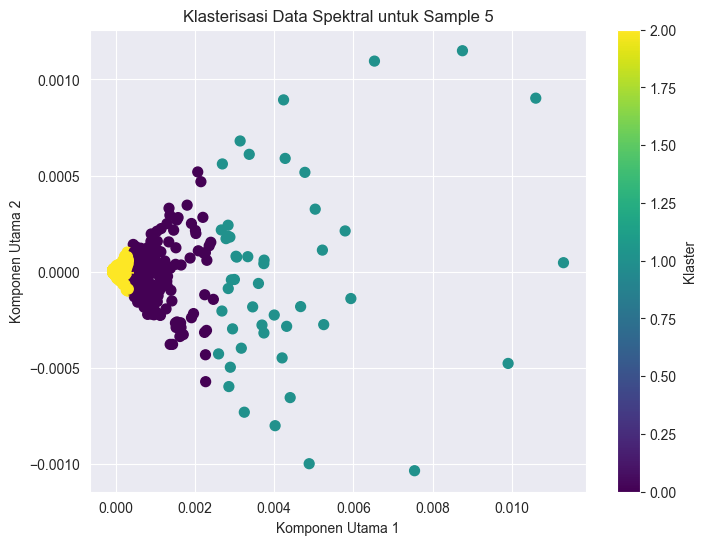

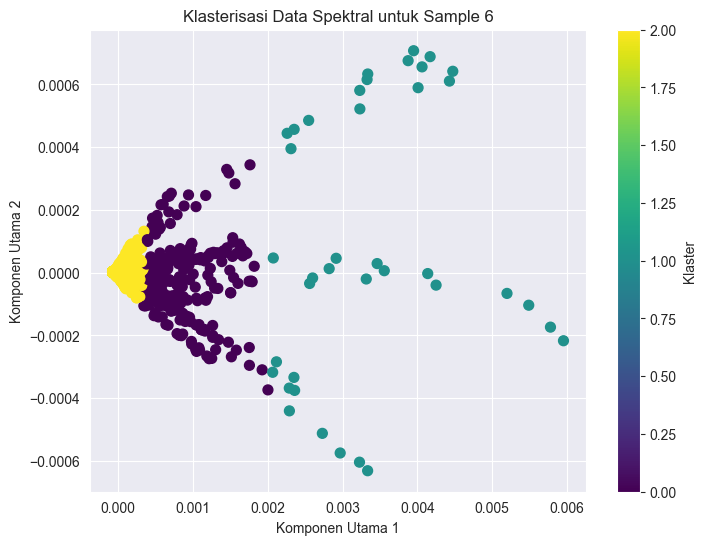

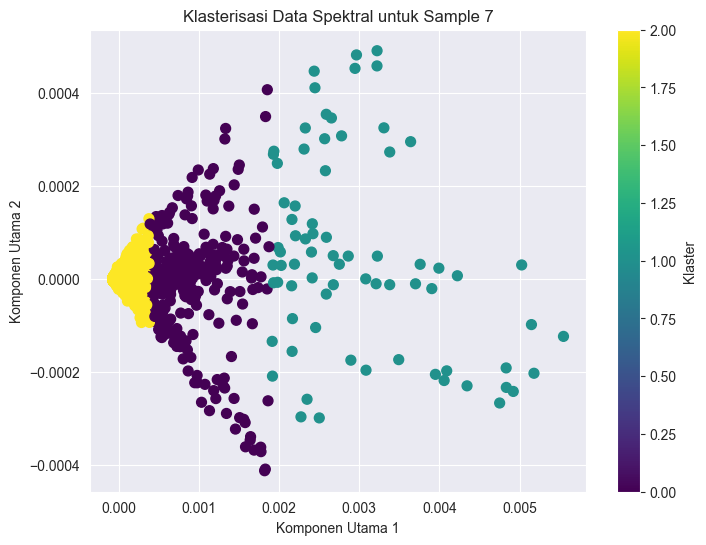

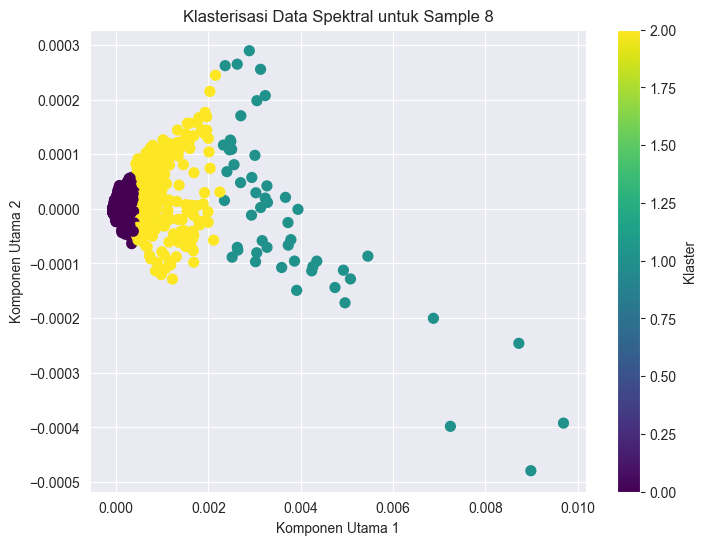

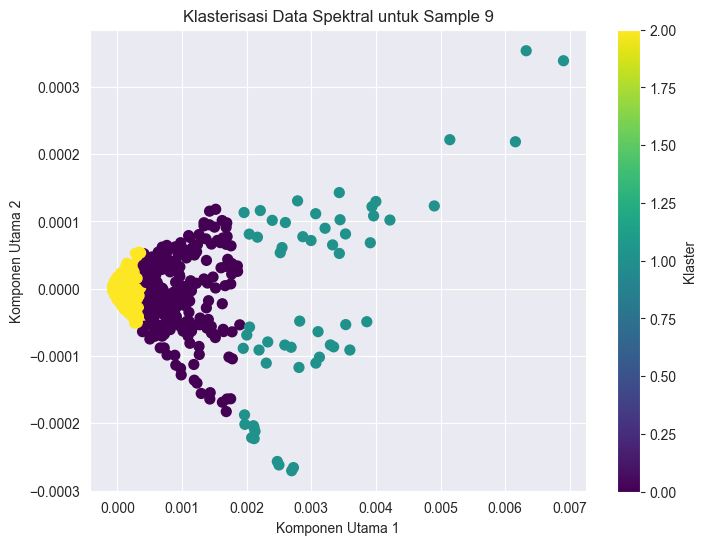

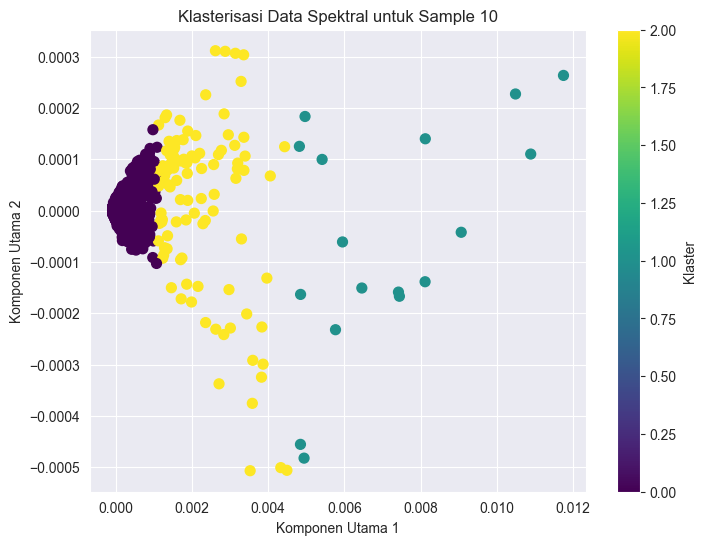

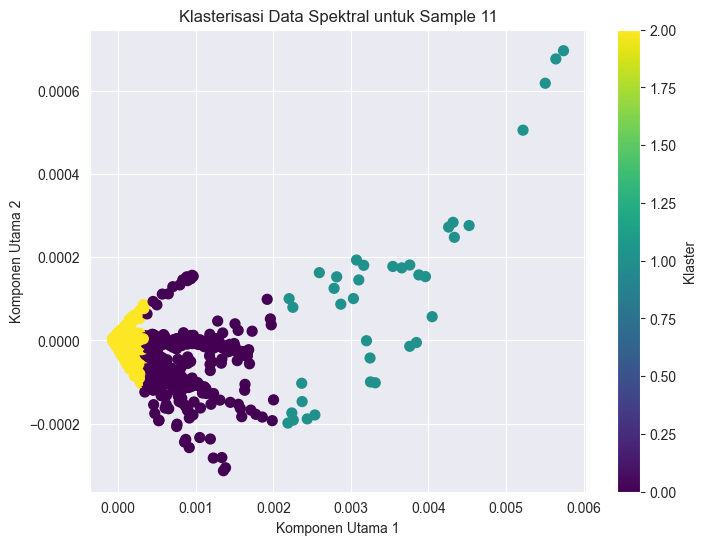

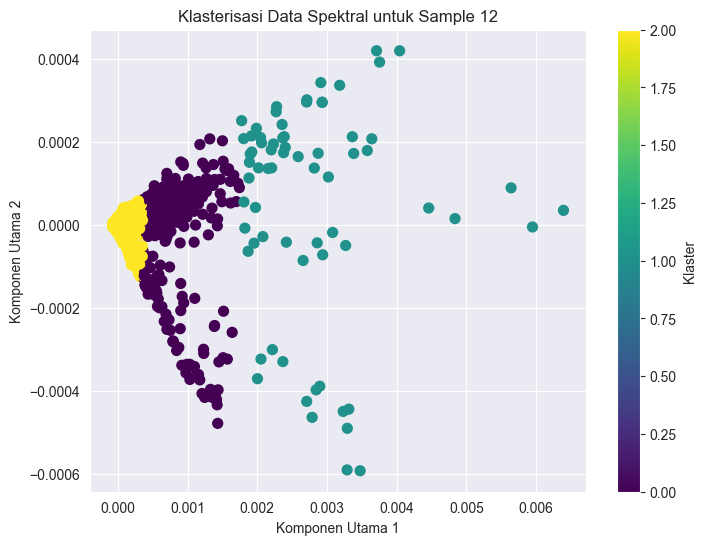

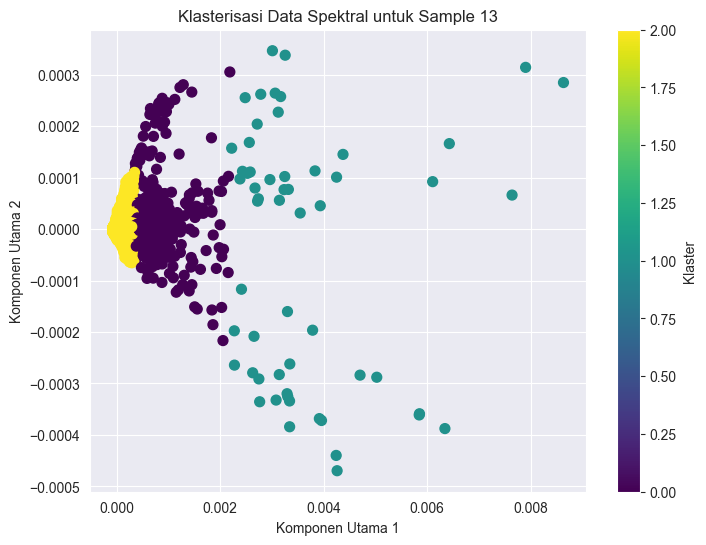

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import sqlite3

# Fungsi untuk mengambil data dari database
def spec(db_path, sample_name, iteration, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    query = """
        SELECT wavelength, intensity
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
    """
    params = [sample_name, iteration]
    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])
    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()
    if not data:
        print(f"No data found for sample: {sample_name}, iteration: {iteration}")
        return None
    wavelengths, intensities = zip(*data)
    return pd.DataFrame({'wavelength': wavelengths, 'intensity': intensities})

# Fungsi untuk normalisasi AUC
def normalize_auc(data):
    return data.apply(lambda x: x / x.sum(), axis=0)

# Fungsi untuk melakukan PCA dan klasterisasi K-means, lalu visualisasi
def cluster_and_visualize_pca(data, sample_name, n_components=2, n_clusters=3):
    # Reduksi dimensi dengan PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data)

    # Klasterisasi K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(principal_components)

    # Visualisasi Scatter Plot Hasil Klasterisasi
    plt.figure(figsize=(8, 6))
    plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis', s=50)
    plt.xlabel('Komponen Utama 1')
    plt.ylabel('Komponen Utama 2')
    plt.title(f'Klasterisasi Data Spektral untuk Sample {sample_name}')
    plt.colorbar(label='Klaster')
    plt.show()

# Parameter dan path database
db_path = 'kopii.db'
lower_bound = 200
upper_bound = 900

# Looping untuk setiap sampel
for sample_num in range(1, 14):  # S1 hingga S24
    sample_name = f'{sample_num}'

    # Mengambil data dari ketiga iterasi untuk tiap sampel
    all_iterations = []
    for iteration in range(1, 4):  # Spektrum perulangan 1, 2, dan 3
        data_df = spec(db_path, sample_name, iteration, lower_bound, upper_bound)
        if data_df is not None:
            data_df['iteration'] = iteration  # Tandai iterasi untuk tiap spektrum
            all_iterations.append(data_df)

    # Menggabungkan ketiga iterasi menjadi satu DataFrame
    if all_iterations:
        combined_df = pd.concat(all_iterations)
        combined_df = combined_df.pivot_table(index='wavelength', columns='iteration', values='intensity').fillna(0)

        # Normalisasi AUC untuk setiap iterasi
        normalized_df = normalize_auc(combined_df)

        # Melakukan klasterisasi dan visualisasi menggunakan PCA
        cluster_and_visualize_pca(normalized_df, sample_name)
    else:
        print(f"No data available for sample: {sample_name}. Skipping...")
        
        


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import sqlite3

# Fungsi untuk mengambil data dari database
def spec(db_path, sample_name, iteration, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    query = """
        SELECT wavelength, intensity, depth, location, location_point
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
    """
    params = [sample_name, iteration]
    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])
    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()
    if not data:
        print(f"Tidak ada data untuk sampel: {sample_name}, iterasi: {iteration}")
        return None
    wavelengths, intensities, depth, location, location_point = zip(*data)
    return pd.DataFrame({'wavelength': wavelengths, 'intensity': intensities})

# Fungsi untuk normalisasi AUC
def normalize_auc(data):
    return data.apply(lambda x: x / x.sum(), axis=0)

# Fungsi untuk melakukan PCA dan klasterisasi K-means, lalu mendeteksi outlier
def detect_outliers_with_kmeans_pca(data, sample_name, n_components=2, n_clusters=3):
    # Reduksi dimensi dengan PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data)

    # Klasterisasi K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(principal_components)

    # Hitung jarak tiap titik ke centroid klasternya
    centroids = kmeans.cluster_centers_
    _, distances = pairwise_distances_argmin_min(principal_components, centroids)

    # Tentukan threshold untuk outlier, misalnya dua kali standar deviasi
    threshold = np.mean(distances) + 2 * np.std(distances)
    outliers = np.where(distances > threshold)[0]

    return [idx for idx in outliers if idx < data.shape[1]]  # Hanya ambil indeks valid

# Fungsi untuk memplot spektrum dari outlier yang terdeteksi tanpa membalikkan PCA
def plot_outlier_spectra(data, outliers, sample_name):
    plt.figure(figsize=(10, 6))
    wavelengths = data.index  # Mengambil indeks panjang gelombang
    
    for idx in outliers:
        plt.plot(wavelengths, data.iloc[:, idx])
    
    plt.xlabel('Panjang Gelombang (nm)')
    plt.ylabel('Intensitas')
    plt.title(f'Spektrum Outlier untuk Sample {sample_name}')
    plt.show()

# Parameter dan path database
db_path = 'tanah_vulkanik.db'
lower_bound = 200
upper_bound = 900

# Looping untuk setiap sampel
for sample_num in range(1, 25):  # S1 hingga S24
    sample_name = f'S{sample_num}'

    # Mengambil data dari ketiga iterasi untuk tiap sampel
    all_iterations = []
    for iteration in range(1, 4):  # Spektrum perulangan 1, 2, dan 3
        data_df = spec(db_path, sample_name, iteration, lower_bound, upper_bound)
        if data_df is not None:
            data_df['iteration'] = iteration  # Tandai iterasi untuk tiap spektrum
            all_iterations.append(data_df)

    # Menggabungkan ketiga iterasi menjadi satu DataFrame
    if all_iterations:
        combined_df = pd.concat(all_iterations)
        combined_df = combined_df.pivot_table(index='wavelength', columns='iteration', values='intensity').fillna(0)

        # Normalisasi AUC untuk setiap iterasi
        normalized_df = normalize_auc(combined_df)

        # Deteksi outlier dengan klasterisasi dan PCA
        outliers = detect_outliers_with_kmeans_pca(normalized_df, sample_name)

        # Plot spektrum dari outlier yang terdeteksi
        plot_outlier_spectra(normalized_df, outliers, sample_name)
    else:
        print(f"Tidak ada data tersedia untuk sampel: {sample_name}. Melewatkan...")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import sqlite3
import pandas as pd

# Fungsi untuk memuat data dari database SQLite untuk klasifikasi
def load_data_for_classification(db_path, sample_names, lower_bound=None, upper_bound=None):
    data, labels = [], []
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    for sample_name in sample_names:
        query = """
            SELECT wavelength, intensity
            FROM processed_spectrum
            WHERE sample_name = ? 
        """
        params = [sample_name]
        if lower_bound is not None and upper_bound is not None:
            query += " AND wavelength BETWEEN ? AND ?"
            params.extend([lower_bound, upper_bound])
        
        cursor.execute(query, params)
        results = cursor.fetchall()
        if results:
            _, intensities = zip(*results)
            data.append(np.array(intensities))
            labels.append(sample_name)  # Menggunakan nama sampel sebagai label klasifikasi
    
    conn.close()
    return np.array(data), np.array(labels)

# Parameter database dan pemuatan data
db_path = 'processed_spectra.db'
sample_names = [f'S{i}' for i in range(1, 25)]
lower_bound, upper_bound = 200, 900
X, y = load_data_for_classification(db_path, sample_names, lower_bound, upper_bound)

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Memastikan X bisa direshape sesuai kebutuhan model
time_steps = 50
total_elements = X.shape[1]

if total_elements % time_steps != 0:
    total_elements = (total_elements // time_steps) * time_steps
    X = X[:, :total_elements]

# Menghitung jumlah fitur per time step dan mereshape X
features = total_elements // time_steps
X = X.reshape(-1, time_steps, features)

# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardisasi data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Model Klasifikasi LSTM
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(len(np.unique(y_encoded)), activation='softmax')  # Softmax untuk klasifikasi multi-kelas
])

# Kompilasi model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Pelatihan model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluasi model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Akurasi Pengujian: {test_accuracy:.4f}")

# Prediksi dan pengambilan label hasil prediksi
y_pred = model.predict(X_test)
predicted_labels = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import sqlite3
import pandas as pd

# Fungsi untuk memuat data dari database SQLite untuk klasifikasi
def load_data_for_classification(db_path, sample_names, lower_bound=None, upper_bound=None):
    data, labels = [], []
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    for sample_name in sample_names:
        query = """
            SELECT wavelength, intensity
            FROM processed_spectrum
            WHERE sample_name = ? 
        """
        params = [sample_name]
        if lower_bound is not None and upper_bound is not None:
            query += " AND wavelength BETWEEN ? AND ?"
            params.extend([lower_bound, upper_bound])
        
        cursor.execute(query, params)
        results = cursor.fetchall()
        if results:
            _, intensities = zip(*results)
            data.append(np.array(intensities))
            labels.append(sample_name)  # Menggunakan nama sampel sebagai label klasifikasi
    
    conn.close()
    return np.array(data), np.array(labels)

# Parameter database dan pemuatan data
db_path = 'processed_spectra.db'
sample_names = [f'S{i}' for i in range(1, 25)]
lower_bound, upper_bound = 200, 900
X, y = load_data_for_classification(db_path, sample_names, lower_bound, upper_bound)

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Memastikan X bisa direshape sesuai kebutuhan model
time_steps = 50
total_elements = X.shape[1]

if total_elements % time_steps != 0:
    total_elements = (total_elements // time_steps) * time_steps
    X = X[:, :total_elements]

# Menghitung jumlah fitur per time step dan mereshape X
features = total_elements // time_steps
X = X.reshape(-1, time_steps, features)

# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardisasi data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Model Klasifikasi LSTM
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(len(np.unique(y_encoded)), activation='softmax')  # Softmax untuk klasifikasi multi-kelas
])

# Kompilasi model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Pelatihan model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Evaluasi model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Akurasi Pengujian: {test_accuracy:.4f}")

# Prediksi dan pengambilan label hasil prediksi
y_pred = model.predict(X_test)
predicted_labels = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 3.2266 - val_accuracy: 0.2000 - val_loss: 3.1612
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.0526 - loss: 3.1762 - val_accuracy: 0.2000 - val_loss: 3.1566
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0000e+00 - loss: 3.1549 - val_accuracy: 0.0000e+00 - val_loss: 3.1553
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.0526 - loss: 3.1196 - val_accuracy: 0.2000 - val_loss: 3.1630
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1053 - loss: 3.0586 - val_accuracy: 0.0000e+00 - val_loss: 3.1805
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1053 - loss: 3.0542 - val_accuracy: 0.2000 - val_loss: 3.1978
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1579 - loss: 3.0507 - val_accuracy: 0.2000 - val_loss: 3.2107
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.1579 - loss: 3.0126 - val_accuracy: 0.2000 - val_los

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Classification Report:
               precision    recall  f1-score   support

          S1       0.00      0.00      0.00       1.0
         S12       0.00      0.00      0.00       1.0
         S17       0.00      0.00      0.00       1.0
         S19       0.00      0.00      0.00       1.0
          S9       0.00      0.00      0.00       1.0

   micro avg       0.00      0.00      0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

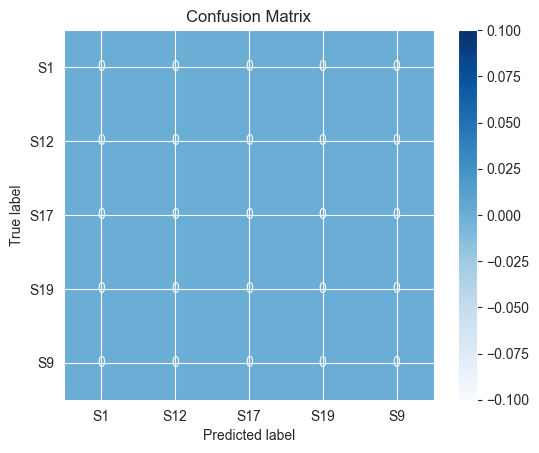

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# 1. Evaluasi Model dengan Confusion Matrix dan Classification Report
y_pred = np.argmax(model.predict(X_test), axis=1)

# Pastikan target_names hanya untuk kelas yang ada di y_test
unique_classes = np.unique(y_test)
target_names = label_encoder.inverse_transform(unique_classes)

# Tampilkan classification report
print("Classification Report:\n", classification_report(y_test, y_pred, labels=unique_classes, target_names=target_names))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

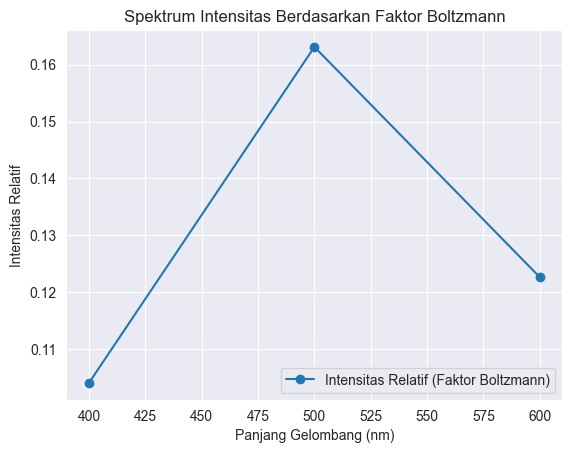

Panjang Gelombang: 400 nm, Populasi Relatif: 0.5205, Kekuatan Osilator: 0.2, Intensitas: 0.1041
Panjang Gelombang: 500 nm, Populasi Relatif: 0.3262, Kekuatan Osilator: 0.5, Intensitas: 0.1631
Panjang Gelombang: 600 nm, Populasi Relatif: 0.1533, Kekuatan Osilator: 0.8, Intensitas: 0.1227


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Data kondisi eksperimen
electron_temperature = 10000  # suhu elektron dalam Kelvin, sesuaikan dengan eksperimen
k_B = 8.617333262145e-5       # konstanta Boltzmann dalam eV/K

# Data contoh dari NIST (sesuaikan dengan data Anda)
energies = np.array([1.0, 2.0, 3.0])  # Energi tingkat dalam eV
degeneracies = np.array([2, 4, 6])    # Faktor degenerasi
oscillator_strengths = np.array([0.2, 0.5, 0.8])  # Kekuatan osilator
wavelengths = np.array([400, 500, 600])  # Panjang gelombang dalam nm

# Fungsi partisi untuk suhu tertentu
partition_function = np.sum(degeneracies * np.exp(-energies / (k_B * electron_temperature)))

# Hitung populasi relatif setiap tingkat energi dengan faktor Boltzmann
populations = (degeneracies * np.exp(-energies / (k_B * electron_temperature))) / partition_function

# Hitung intensitas relatif untuk setiap transisi
intensities = populations * oscillator_strengths

# Plot spektrum intensitas relatif
plt.plot(wavelengths, intensities, 'o-', label='Intensitas Relatif (Faktor Boltzmann)')
plt.xlabel('Panjang Gelombang (nm)')
plt.ylabel('Intensitas Relatif')
plt.title('Spektrum Intensitas Berdasarkan Faktor Boltzmann')
plt.legend()
plt.show()

# Menampilkan intensitas relatif dan parameter lain untuk tiap panjang gelombang
for wl, pop, osc_strength, intensity in zip(wavelengths, populations, oscillator_strengths, intensities):
    print(f"Panjang Gelombang: {wl} nm, Populasi Relatif: {pop:.4f}, Kekuatan Osilator: {osc_strength}, Intensitas: {intensity:.4f}")